<a href="https://colab.research.google.com/github/anilaksu/Natural-Language-Processing-Codes/blob/main/NLP_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Fundamentals


## 1 Word Embeddings
**The problem of understanding text is not new:**

* Machine learning models for text used ***hand crafted features*** from data.   
    * **Bag-of-Words:** The count of tokens (words, n-grams)
    * **TF-IDF:**  Term frequency-inverse document frequency is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. Works by increasing proportionally to the number of times a word appears in a document but is offset by the number of documents that contain the word.  

* ***Syntactic relationships*** in text. **Syntax** is the study of sentence structure and the rules of grammar.
    - POS tags
    - Stemming
    - Lemmatization   

* ***Probabilistic Topic Modeling*** reveals hidden thematic structure of documents.
    - Latent Dirichlet allocation (**LDA**) is a generative model for collections of discrete data such as text corpora.
    - Represents documents as a bag-of-words
    - Document structure is neglected

**Challenge**

* ***Semantics***: Features like word count do not actually capture the meaning of a word or the context in which it is used, that is, the semantics. ***Semantics*** is the study of the meaning of sentences.

**Idea**
* Word Embeddings ***encode the meaning and context*** of words as a vector of numbers (because ML models only understand numbers).

* Word Embeddings are ***not defined by humans*** but are ***learnt by a ML model*** during training.
* No need to handcraft features

* **Important:** Embedded features are ***latent***, that is, they are not directly observable and interpretable to us!

##1.2 What are Word Embeddings?

* Word embeddings are simply vectors of numbers (row of real valued numbers) that represent the meaning of a word based on the contexts it appears in.   

* Each point (i.e., column) in a word vector captures a dimension of the word’s meaning.  

* Semantically similar words (i.e., words that are used in a similar context) will have similar vectors.   

* Distance between two vectors = semantic similarity.  

* Word vectors lend themselves to mathematical operators:
  - Addition
  - Subtraction
  - Summing
  - Averaging

***For Example:***

${WV(king) — WV(man) + WV(woman) = WV(queen)}$

- Subtract one meaning from the word vector for king (i.e., "maleness"), add another meaning (i.e., "femaleness")
- Show that this new word vector (king — man + woman) is most similar to the word vector for queen.


In [ ]:
# Here we set our working directory in our google drive to access datasets externally
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks/NLP
!ls # special shell command to view the files in the home directory of the notebook environment

MessageError: ignored

In [ ]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from PIL import Image
from io import BytesIO

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 2 Dataset

- We use a dataset that was obtained by scraping book details from [Goodreads](https://goodreads.com) pertaining to business and non-fiction genres.
- The data consist of 2382 books.
- There are two genres:
  - Business (1185 books)
  - Fiction (1197 books)
- The available book features include:
  - Title
  - Short description
  - Author
  - Rating
  - Book image link

 Dataset Source: https://github.com/sdhilip200/Content-Based-Recommendation---Good-Reads-data

In [ ]:
# 2. Read the data
books = pd.read_csv("books.csv", index_col=False)
books.head()

FileNotFoundError: ignored

## 3Text Preprocessing

Since we want to use the book description to compute embeddings, we first clean the book description i.e. text preprocessing and store the cleaned description in a new variable called ‘cleaned’.

In [ ]:
# 1. Utitlity functions
# a. Remove ASCII
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

# b. Make all words lower case
def make_lower_case(text):
    return text.lower()

# c. Remove stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# d. Remove HTML
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# e. Remove punctuatiom
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [ ]:
# Let's clean up!

# 2. Make sure the descritions are of type string and create new column to operate on "cleaned"
books['cleaned'] = books['Desc'].astype(str)

# 3. Pass data into utility functions
books['cleaned'] = books.cleaned.apply(remove_non_ascii)
books['cleaned'] = books.cleaned.apply(make_lower_case)
books['cleaned'] = books.cleaned.apply(remove_stop_words)
books['cleaned'] = books.cleaned.apply(remove_punctuation)
books['cleaned'] = books.cleaned.apply(remove_html)

We then split each description into word tokens and store it in a list called ‘corpus’ for training our word2vec model.

In [ ]:
# 4. Split the cleaned description into word tokens
corpus = []
for row in books['cleaned']:
    corpus.append(row.split())

## 4 Transfer Learning: Fine-Tuning a Word2Vec Model

**Problem:**
* Training our own word embeddings is an expensive process (compute power and time) and also requires a large dataset. We don’t have a large dataset as we scraped Goodreads data which only pertains to the genres of business and fiction.

**Solution:**
* Use Google pre-trained word embeddings which were trained on a large corpus, including Wikipedia, news articles and more.

**Problem:**
* However, since the model was trained on a large corpus including Wikipedia articles, news etc. it may not have a similar vocabulary as the Goodreads dataset. For example: It may not know that the words `Harry` and `Hermione` should be close together and may not even contain the word `Hermione` in its vocabulary, since it may not have come across Harry Potter

In order to add the unseen words, present in the Goodreads vocabulary to the model, and we fine-tune the pre-trained model on the Goodreads dataset corpus.

**Solution:**
* We can add unseen words to the vocabulary of the model and teach it new contexts of words by **fine-tuning a pre-trained model**. This means that we use the weights of the existing pre-trained model and adjust them through training, so it learns the new information present in the Goodreads corpus.

**Word2Vec is a popular model to train and obtain word embeddings**

* We just used a pre-trained Word2Vec model in our example above  

* Word2Vec is a computationally efficient model composed of a **two-layer neural network** (i.e., a shallow neural network)  

* The model ***learns word embeddings from raw text*** and is trained to reconstruct linguistic contexts of words.  

* The model ***input*** is a large text corpus.

* The model ***output*** is a higher-dimensional vector space (i.e., word embeddings) where ***each unique word in the text corpus is embedded into a vector in this space***.   

* Words are embedded into word vectors such that
   - ***words that share common contexts*** in the text corpus ***have similar word vectors***
   - and are thus are ***located in close proximity*** to one another in the vector space.

An **epoch** in machine learning means one complete pass of the training dataset through the algorithm. This epoch’s number is an important hyperparameter for the algorithm. It specifies the number of epochs or complete passes of the entire training dataset passing through the training or learning process of the algorithm.

In [ ]:
# 5. Initialise the Word2Vec Model
google_model = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# 1. Initialise the Word2Vec Model with embedding size = 300, window = 5
# and min_count = 2 i.e. the minimum number of times a word should appear in the corpus
google_word2vec = Word2Vec(vector_size=300, window=5, min_count=2)

In [ ]:
%%time
# Note: We have downloaded the pre-trained model already when visualising word vectors using t-SNE

#Step 1: We start by incorporating the vocabulary of our specific corpus into the google model
google_word2vec.build_vocab(corpus)

#Step 2: We obtain the word vectors for the words in the vocabulary that are already present in pre-trained word2vec model.
#google_word2vec.intersect_word2vec_format('word2vec-google-news-300', lockf=1.0, binary=True)
#Word2Vec.intersect_word2vec_format(google_word2vec,binary=False)
#w2v_model.wv.intersect_word2vec_format(pretrained_dir + 'word2vec-google-news-300', binary=True)

#Step 3: We fine-tune the model to learn new contexts of words in our corpus
google_word2vec.train(corpus, total_examples=google_word2vec.corpus_count, epochs = 5)

CPU times: user 4.06 s, sys: 15.5 ms, total: 4.08 s
Wall time: 2.29 s


(1242242, 1338465)

In [ ]:
# 2. Print the top 10 most similar words using cosine similarity
google_word2vec.wv.most_similar(positive=["marketing"])

[('startup', 0.9969622492790222),
 ('entrepreneur', 0.9930452704429626),
 ('lean', 0.9929942488670349),
 ('corpse', 0.9857125878334045),
 ('strategy', 0.9855636358261108),
 ('successful', 0.9839081764221191),
 ('fussy', 0.9833547472953796),
 ('georgetown', 0.9831987619400024),
 ('captivity', 0.981328547000885),
 ('concise', 0.981105387210846)]

In [ ]:
google_word2vec.wv.most_similar(positive=["castle"])

[('chest', 0.9996496438980103),
 ('blockbusters', 0.9996470212936401),
 ('swerves', 0.9996469020843506),
 ('affliction', 0.9996421933174133),
 ('nightclub', 0.9996344447135925),
 ('haber', 0.9996157884597778),
 ('emotionally', 0.9996073246002197),
 ('cartel', 0.9995984435081482),
 ('paris', 0.9995914697647095),
 ('resonated', 0.9995852708816528)]

## 5 Averaging Word Vectors

- As you now know, Word2vec takes a word and gives a D-dimension vector.
- Since we have book descriptions which are sentences or sequences of words, we first need to split the sentences into words and find the vectors representation for each word in the sentence.

**Consider a book description has N words. Let’s denote the words as** ${w_1, w_2, w_3, w_4 …w_N}$.

1. We first calculate Word2Vec for all the N words.
2. We then sum all the word vectors and divide the same by the total number of words in the description to obtain the average word vector (V1).

$${ V_1 = \frac{W2V(w_1) + W2V(w_2) + W2V(w_3) + W2V(w_4) + ….. + W2V(w_N)}{N} }$$

- Here, vectors are in D-dimensional space, where D = 300.

- N = number of words in description 1

- v1 = vector representation of book description 1

- In this way, each book description can be converted into a unique vector.

In [ ]:
# Generate the average word2vec for the each book description

# 1. Define a function that we can call for each book description
def average_vectors(df):
    # Creating a list for storing the vectors (description into vectors)
    embeddings = []

    # For each book, create an average vector from all the words in its description
    for line in df['cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in list(google_word2vec.wv.index_to_key):
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_word2vec.wv[word]
                else:
                    avgword2vec = avgword2vec + google_word2vec.wv[word]

        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            embeddings.append(avgword2vec)

    return embeddings

# 2. Apply function to all book descriptions
book_embeddings = average_vectors(books)

## 6 Recommend Books

We now use these average book embeddings to find similar books and make recommendations

In [ ]:
# Function to recommend the Top 5 similar books
def recommendations(title, book_embeddings, books):

    # 1. Find cosine similarity for the vectors
    cosine_similarities = cosine_similarity(book_embeddings, book_embeddings)

    # 2. Take the title and book image link and store in new data frame called books
    book_covers = books[['title', 'image_link']]

    # 3. Create a mapping from book title to index
    indices = pd.Series(books.index, index = books['title']).drop_duplicates()

    # 4. Get the index of the book title we need recommendations from
    idx = indices[title]

    # 5. Obtain the cosine similarities of the title with all other book from the similarity matrix
    # Sim scores is a list of tuples of (book_index, cosine_simialrity)
    sim_scores = list(enumerate(cosine_similarities[idx]))

    # 6. Sort similarity scores by descending order
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)

    # 7. Pick the top 5 most similar books. Exclude index 0 as that would be the book itself
    sim_scores = sim_scores[1:6]

    # 8. Obtain the book indices of the top 5 books
    book_indices = [i[0] for i in sim_scores]

    # 9.Obtain the book cover and title of the top 5 books
    recommend = book_covers.iloc[book_indices]
    recommend.reset_index(inplace=True)

    # 10. Output the book image
    plt.figure()
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        axes[index].imshow(img)

<Figure size 640x480 with 0 Axes>

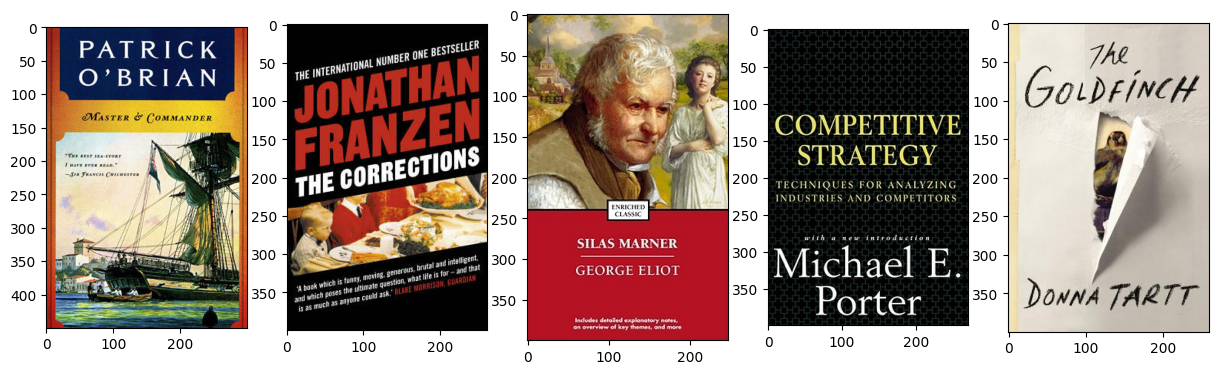

In [ ]:
# Let's call our function and pass it a book title to get recommendations for similar books
recommendations("Harry Potter and the Prisoner of Azkaban", book_embeddings, books)

## 7 Visualize the Semantic Similarity of Words
-	Words that are similar or appear in similar contexts
-	Word with similar context have similar word vectors
Let’s do some visual discovery of word similarities!

**For this visualization of word vectors**
* We will load the Google Pre-trained model for word vectors using 'gensim' a popular NLP library.  

* By pre-trained we mean that the model has already been trained on some data and has learnt the word vector representations.
* Remember that Word Embeddings are not defined by humans but are learnt by an ML model during training.

* We will obtain the word embeddings for some words and visualize how similar they are using t-SNE.

In [ ]:
# 3. Create a string of words we are interested in
words = "man woman boy girl king queen water"

# 4. Turn the string into individual tokens
word_tokens = words.split(' ')

# 5. Get word vectors from pre-trained word embedding for all tokens of our string
word_vectors = [google_model[x] for x in word_tokens]

# 6. Show how long the vectors are
print(f"Dimensions: {len(word_vectors[0])}")

# 7- Show the first 10 "columns" for the word 'man'
print(f"First 10 dimensions of the word embedding for 'man': {word_vectors[0][:10]}")

Dimensions: 300
First 10 dimensions of the word embedding for 'man': [ 0.32617188  0.13085938  0.03466797 -0.08300781  0.08984375 -0.04125977
 -0.19824219  0.00689697  0.14355469  0.0019455 ]


### 7.1 Dimensionality Reduction with t-SNE

- We can use t-SNE to reduce the dimensionality of the word vectors from 300 dimensions to 2 dimensions

In [ ]:
# 1. Import required package
from sklearn.manifold import TSNE

# 2. Set value for perplexity: we have very few objects (i.e., words), therefore we set a very low value
perp = 3  # perplexity of similarity kernel

# 3. Set multiple Seeds for random initializations
sds=[441430660, 441430937, 441431215, 441431495, 441431773, 441432054, 441432333, 441432614, 441432896, 441433177]
KL = []

# 4. Find best seed (i.e., lowest KL divergence)
for s in sds:
    tsne = TSNE(n_components = 2, perplexity = perp, random_state=s)
    # The function accepts numpy array so converted word_vectors into numpy array
    X_tsne = tsne.fit_transform(np.array(word_vectors))
    KL.append(tsne.kl_divergence_)
    print(tsne.kl_divergence_, end=" ")

# 5. Fit Best Model
# The function accepts numpy array so converted word_vectors into numpy array
Y = TSNE(n_components = 2, verbose=True, perplexity = perp, random_state=sds[KL.index(min(KL))]).fit_transform(np.array(word_vectors))

0.02430826425552368 0.019101258367300034 0.017514564096927643 0.018061183393001556 0.026093583554029465 0.01684991642832756 0.0181428212672472 0.01806822046637535 0.05241573974490166 0.05344919487833977 [t-SNE] Computing 6 nearest neighbors...
[t-SNE] Indexed 7 samples in 0.000s...
[t-SNE] Computed neighbors for 7 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 7 / 7
[t-SNE] Mean sigma: 1.401266
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.954208
[t-SNE] KL divergence after 1000 iterations: 0.016850


### 7.2 Visualization in an Interactive Map with Altair


- We can now visualize how similar words are based on their latent meanings on a map by treating the 2 dimensions of t-SNE as X and Y coordinates.

Altair is a powerful tool for interactive visualization in Python https://altair-viz.github.io/index.html

In [ ]:
# 1. Create a new DataFrame that holds all the information we need for our map
import pandas as pd
df = pd.DataFrame(
    {'x': Y[:,0],
     'y': Y[:,1],
     'txt': words.split()
    })

# 2. Import Altair
import altair as alt

# 3. Plot the dataset by referencing DataFrame column names
base = alt.Chart(df).encode(
    x=alt.X('x', axis=alt.Axis(title="X", grid=True, labels=False), scale=alt.Scale(domain=[-500, 525])),
    y=alt.Y('y', axis=alt.Axis(title="Y", grid=True, labels=False), scale=alt.Scale(domain=[-300, 300]))
)

base.mark_circle(size=100) + base.mark_text(dx=25,fontSize=12).encode(text='txt').interactive().properties(height=600,width=600,title='Similarity of Word Vectors')

alt.LayerChart(...)

- The words `man` and `woman` are close together
  - and are also close to `boy` and `girl`.
- The words `king` and queen are close to each other.
- All words are further away from `water`.

### 7.3 Heat Map of Word Vectors

-	The value of representing words as word vectors comes from being able to compare words to see how similar they are.
-	When dealing with vectors, a common way to calculate a similarity score is cosine similarity.

<Axes: >

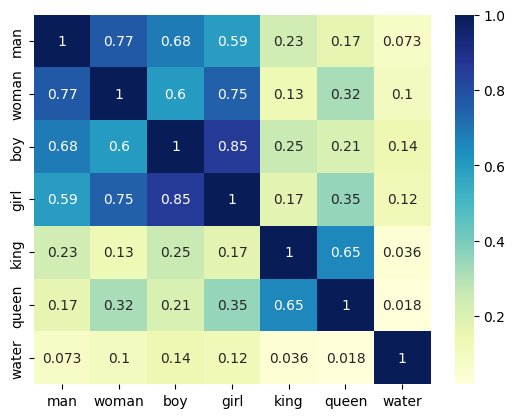

In [ ]:
# 1. Import required packages
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# 2. Calculate Cosine Similarity for first word (man) - optional
cos_sim = cosine_similarity(word_vectors, np.tile(word_vectors[0], (7, 1)))[:, 1]

# 3. Generate Cosine Similarity Matrix
sim_matrix = cosine_similarity(word_vectors, word_vectors)

# 4. Get actual words
word_labels = [str(word) for word in word_tokens]

# 5. Generate Heat Map
sns.heatmap(sim_matrix, annot=True, xticklabels=word_labels, yticklabels=word_labels, cmap="YlGnBu")

## 7.4 Operations on Embeddings

Since word vectors are numbers, we can perform operations like addition, subtraction and averaging.   

- What is the motivation behind doing this?
- What's going on under the hood?
- Let's take a look!

**Example 1**
In the example we had when introducing word embeddings, we said that we could so something like this

$WV(king) — WV(man)+WV(woman)=WV(queen)$

That is, subtract one meaning from the word vector for king (i.e. maleness), add another meaning (femaleness) and that this new word vector (king — man + woman) is most similar to the word vector for queen.

In [ ]:
# 1. Define Words (tokens)
words = ["king", "man", "woman"]

# 2. Get vectors from pre-trained model
word_vectors = [google_model[x] for x in words]

# 3. Do the math! result = king - man + woman
result = word_vectors[0] - word_vectors[1] + word_vectors[2]

# 4. Most similar words to the result (note that as a heuristic, you might need to ignore the first, that is, most similar result)
google_model.most_similar(positive=[result], topn=5)

[('king', 0.8449392318725586),
 ('queen', 0.7300517559051514),
 ('monarch', 0.645466148853302),
 ('princess', 0.6156251430511475),
 ('crown_prince', 0.5818676352500916)]

**Example 2:** We have 2 people Dan and Dave who like different sets of animals.

*We want to know how similar their preferences for animals are!*

1. Average the word vectors of the animals each of them lokes like to get a single vector that represents their favourites

2. Compare averaged vectors

In [ ]:
# 1. Average vectors for Dave
dave_favorite_animals = ["panther", "tiger", "lion"]
dave_favorite_vectors = [google_model[x] for x in dave_favorite_animals]
dave_favorite = np.average(dave_favorite_vectors, axis=0)

# 2. Average vectors for Dan
dan_favorite_animals = ["whale", "shark", "dolphin"]
dan_favorite_vectors = [google_model[x] for x in dan_favorite_animals]
dan_favorite = np.average(dan_favorite_vectors, axis=0)

# 3. Compare
print("Similarity of of Dave's and Dan's preferences for animals: " , cosine_similarity([dave_favorite, dan_favorite])[0][1])

Similarity of of Dave's and Dan's preferences for animals:  0.5677123
